# Check hyperparameter sweep results.

In [1]:
"""Imports."""

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

In [7]:
"""Load data."""

import load_data
import importlib
importlib.reload(load_data)

BASE_RESULTS_DIR = Path(
    "../../cache/modeling/"
    "hyperparams/triangle_gain"
    # "hyperparams/triangle_switching"
    # "hyperparams/triangle_slot_partition"
    # "hyperparams/triangle_slot_partition"
    # "hyperparams/triangle_slot"
    # "hyperparams/triangle_slot"
    
    # "hyperparams/ring_gain"
    # "hyperparams/ring_switching"
    # "hyperparams/ring_slot_partition"
    # "hyperparams/ring_slot_partition"
    # "hyperparams/ring_slot"
    # "hyperparams/ring_slot"
    
    # "controls_hyperparams/triangle_gain_dmfc"
    # "controls_hyperparams/triangle_switching_dmfc"
    # "controls_hyperparams/triangle_slot_partition_dmfc"
    
    # "controls_hyperparams/triangle_gain_fef"
    # "controls_hyperparams/triangle_switching_fef"
    # "controls_hyperparams/triangle_slot_partition_fef"
    
    # "controls_hyperparams/triangle_gain_good"
    # "controls_hyperparams/triangle_switching_good"
    # "controls_hyperparams/triangle_slot_partition_good"
    
    # "synthetic_dataset_hyperparams/triangle_gain/triangle_gain"
    # "synthetic_dataset_hyperparams/triangle_gain/triangle_slot_partition"
    # "synthetic_dataset_hyperparams/triangle_gain/triangle_switching"
    
    # "synthetic_dataset_hyperparams/triangle_switching/triangle_gain"
    # "synthetic_dataset_hyperparams/triangle_switching/triangle_slot_partition"
    # "synthetic_dataset_hyperparams/triangle_switching/triangle_switching"
    
    # "synthetic_dataset_hyperparams/triangle_slot_partition/triangle_gain"
    # "synthetic_dataset_hyperparams/triangle_slot_partition/triangle_slot_partition"
    # "synthetic_dataset_hyperparams/triangle_slot_partition/triangle_switching"
)

subdirectory_keys = ['subject', 'session', 'random_seed', 'time_sigma']
results_df, loss_df, progress_df = load_data.load_all_datasets(
    BASE_RESULTS_DIR, subdirectory_keys=subdirectory_keys, check_product_space=True,
)

> /Users/nicholaswatters/Desktop/grad_school/research/multi_object_memory_paper/phys_modeling/monitor_sweeps/load_data.py(131)_load_sessions()
    129 
    130             pdb.set_trace()
--> 131         results_df, loss_df, progress_df = _load_sessions(
    132             directory,
    133             subdirectory_keys=subdirectory_keys[1:],

{'subject': 'Perle', 'session': '2022-05-31', 'random_seed': '0', 'time_sigma': '0'}
[]


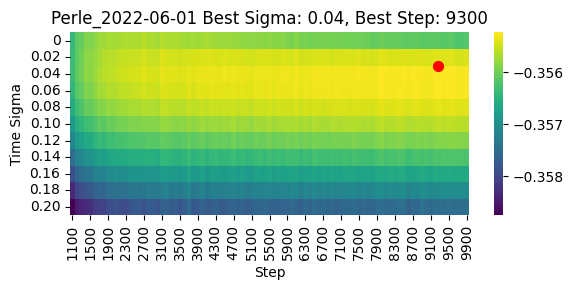

In [5]:
"""Plot results."""

for subject_session in sorted(progress_df["subject_session"].unique()):
    if subject_session != "Perle_2022-06-01":
        continue
    tmp_df = progress_df[
        (progress_df["subject_session"] == subject_session)
        & (progress_df["step"] > 1000)
    ]
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    sigmas = sorted(tmp_df["time_sigma"].unique())
    num_sigmas = len(sigmas)
    steps = sorted(tmp_df["step"].unique())
    num_steps = len(steps)
    random_seeds = sorted(tmp_df["random_seed"].unique())
    num_random_seeds = len(random_seeds)
    image = np.nan * np.ones((num_sigmas, num_steps, num_random_seeds))
    for i_random_seed, random_seed in enumerate(random_seeds):
        for i_sigma, sigma in enumerate(sigmas):
            for i_step, step in enumerate(steps):
                tmp = tmp_df[
                    (tmp_df["random_seed"] == random_seed) &
                    (tmp_df["step"] == step) &
                    (tmp_df["time_sigma"] == sigma)
                ]
                if not tmp.empty:
                    image[i_sigma, i_step, i_random_seed] = tmp["test_mean_log_likelihood"].values[0]
    image_mean = image.mean(axis=2)
    
    # Compute best sigma and step
    title_suffix = ''
    if np.all(np.isfinite(image_mean)):
        best_idx = np.unravel_index(np.nanargmax(image_mean, axis=None), image_mean.shape)
        best_sigma = float(sigmas[best_idx[0]])
        best_step = int(steps[best_idx[1]])
        title_suffix = f" Best Sigma: {best_sigma}, Best Step: {best_step}"
        ax.scatter(best_idx[1], best_idx[0], color='red', s=50, zorder=5)

    # Heatmap
    sns.heatmap(image_mean, ax=ax, cmap="viridis", cbar=True)

    # Get x ticks and y ticks
    x_indices = [int(x.get_text()) for x in ax.get_xticklabels()]
    y_indices = [int(y.get_text()) for y in ax.get_yticklabels()]
    xticklabels = [steps[i] for i in x_indices]
    yticklabels = [sigmas[i] for i in y_indices]
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_yticklabels(yticklabels, rotation=0)

    # Axis labels
    ax.set_ylabel("Time Sigma")
    ax.set_xlabel("Step")
    ax.set_title(subject_session + title_suffix)
    fig.tight_layout()